In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import os
from sklearn.model_selection import train_test_split

#### Listing the directories and splitting the images

In [2]:
base_dir = r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages'
categories = ['Cat', 'Dog']

train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

# Create directories if they do not exist
for dir_path in [train_dir, val_dir, test_dir]:
    for category in categories:
        os.makedirs(os.path.join(dir_path, category), exist_ok=True)

# Function to split data and move files
def split_and_move_images(category, base_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.15):
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    
    # Split the images into train, validation, and test sets
    train_images, temp_images = train_test_split(images, train_size=train_size, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=val_size/(1-train_size), random_state=42)
    
    # Moving our files to train directory
    for img in train_images:
        shutil.move(os.path.join(category_path, img), os.path.join(train_dir, category, img))

    # Moving our files to validation directory
    for img in val_images:
        shutil.move(os.path.join(category_path, img), os.path.join(val_dir, category, img))
        
    # Moving our files to test directory
    for img in test_images:
        shutil.move(os.path.join(category_path, img), os.path.join(test_dir, category, img))

# Split and moved images for each category
for category in categories:
    split_and_move_images(category, base_dir, train_dir, val_dir, test_dir)

ValueError: With n_samples=0, test_size=None and train_size=0.7, the resulting train set will be empty. Adjust any of the aforementioned parameters.

#### Counting the images in each foleders that are created above

In [3]:
import os

folder_path = r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages'
categories = [r'Train\Dog', r'Train\Cat', r'Test\Dog', r'Test\Cat', r'Validation\Dog', r'Validation\Cat']

# Count the number of items in each category
for i in categories:
    path = os.path.join(folder_path, i)
    items = os.listdir(path)
    num_items = len(items)
    print(f"There are {num_items} items in the folder '{path}'.")

# Check for zero-length files
files = []
for i in categories:
    path = os.path.join(folder_path, i)
    items = os.listdir(path)
    for file in items:
        file_path = os.path.join(path, file)  # Get full file path
        if os.path.getsize(file_path) > 0:  # Check if the file is non-empty
            files.append(file)
        else:
            print(file_path ,file + ' is zero length')  # Fix space in message


There are 8748 items in the folder 'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Train\Dog'.
There are 8734 items in the folder 'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Train\Cat'.
There are 1875 items in the folder 'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Test\Dog'.
There are 1872 items in the folder 'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Test\Cat'.
There are 1875 items in the folder 'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Validation\Dog'.
There are 1871 items in the folder 'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Validation\Cat'.


This looks like a well balenced splitting of images

Removing the images that are blank or with no data

In [4]:
for i in [r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Train\Dog\11702.jpg', 
          r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Train\Dog\666.jpg']:
    os.remove(i)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\PROJECTS\\sample_projects\\CatsVSDogs\\PetImages\\Train\\Dog\\11702.jpg'

#### Building our Model

In [5]:
from PIL import Image

# Open an image file
image_path = r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Train\Dog\11705.jpg'
with Image.open(image_path) as img:
    # Get dimensions
    width, height = img.size

    print(f"Width: {width}, Height: {height}")

Width: 333, Height: 500


In [6]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Image sizes are varying i.e the width and height are different for the pics, so to maintain some standard size for all the images we fixed the 
`height` : 150, 
  `width`  : 150

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [8]:
training_dir = r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Train'
train_datagen = ImageDataGenerator(rescale=1.0/255.) #scaling the pixels for the images

train_generator = train_datagen.flow_from_directory(
    training_dir,
    batch_size=250,
    class_mode='binary',
    target_size=(150, 150)
)

Found 17482 images belonging to 2 classes.


In [9]:
test_dir = r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Train'
test_datagen = ImageDataGenerator(rescale=1.0/255.) #scaling the pixels for the images

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=250,
    class_mode='binary',
    target_size=(150, 150)  
)

Found 17482 images belonging to 2 classes.


In [10]:
valid_dir = r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Validation'
valid_datagen = ImageDataGenerator(rescale=1.0/255.) #scaling the pixels for the images

# Fix the target_size syntax issue
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    batch_size=250,
    class_mode='binary',
    target_size=(150, 150)  # target_size should be passed as a tuple
)

Found 3746 images belonging to 2 classes.


In [11]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def filter_missing_files(data_dir):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            file_path = os.path.join(root, file)
            if not os.path.isfile(file_path):
                print(f"File not found and skipped: {file_path}")
               
# Filtering missing files before generating data
filter_missing_files(r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages')

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def safe_image_loader(file_path):
    try:
        img = tf.keras.utils.load_img(file_path, target_size=(150, 150))
        return img
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

datagen = ImageDataGenerator(rescale=1./255)

# Modifying your generator to skip missing files:
train_generator = datagen.flow_from_directory(
    directory=r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages\Train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 17482 images belonging to 2 classes.


In [13]:
from PIL import Image
import os

# Path to the dataset
folder_path = r'C:\PROJECTS\sample_projects\CatsVSDogs\PetImages'

# this is a function to check if an image is corrupted
def check_image(path):
    try:
        img = Image.open(path)  # Trying to open the image
        img.verify()            # Verifying if it's a valid image
        return True             # if Image is valid
    except (IOError, SyntaxError) as e:
        print(f"Corrupted image file: {path}")
        return False            # if Image is corrupted

# Iterating through all image files in the dataset
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        if not check_image(file_path):
            os.remove(file_path)  # Removing corrupted image
            print(f"Removed corrupted image: {file_path}")

C:\PROJECTS\sample_projects\project1\env\lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [14]:
try:
    history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                        validation_data=test_generator, validation_steps=6)
except FileNotFoundError as e:
    print(f"Error: {e}")

Epoch 1/15
90/90 [==============================] - 39s 410ms/step - loss: 0.7601 - acc: 0.5632 - val_loss: 0.6530 - val_acc: 0.6580
Epoch 2/15
90/90 [==============================] - 31s 350ms/step - loss: 0.6267 - acc: 0.6542 - val_loss: 0.5899 - val_acc: 0.6947
Epoch 3/15
90/90 [==============================] - 30s 332ms/step - loss: 0.5904 - acc: 0.6878 - val_loss: 0.5122 - val_acc: 0.7493
Epoch 4/15
90/90 [==============================] - 32s 358ms/step - loss: 0.5654 - acc: 0.7108 - val_loss: 0.5108 - val_acc: 0.7600
Epoch 5/15
90/90 [==============================] - 32s 360ms/step - loss: 0.5460 - acc: 0.7302 - val_loss: 0.4951 - val_acc: 0.7500
Epoch 6/15
90/90 [==============================] - 34s 380ms/step - loss: 0.5249 - acc: 0.7432 - val_loss: 0.4718 - val_acc: 0.7680
Epoch 7/15
90/90 [==============================] - 31s 346ms/step - loss: 0.4868 - acc: 0.7611 - val_loss: 0.4457 - val_acc: 0.7973
Epoch 8/15
90/90 [==============================] - 30s 337ms/step - 

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

# Early stopping to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_acc', 
                             save_best_only=True, mode='max')

# Train the model
history = model.fit(train_generator, epochs=15, steps_per_epoch=90, 
                    validation_data=test_generator, validation_steps=6,
                    callbacks=[early_stopping, lr_scheduler, checkpoint])

Epoch 1/15
90/90 [==============================] - 50s 558ms/step - loss: 0.2295 - acc: 0.9104 - val_loss: 0.2045 - val_acc: 0.9213 - lr: 0.0010
Epoch 2/15
90/90 [==============================] - 34s 375ms/step - loss: 0.2194 - acc: 0.9174 - val_loss: 0.1995 - val_acc: 0.9207 - lr: 0.0010
Epoch 3/15
90/90 [==============================] - 38s 419ms/step - loss: 0.2249 - acc: 0.9167 - val_loss: 0.1984 - val_acc: 0.9233 - lr: 0.0010
Epoch 4/15
90/90 [==============================] - 37s 415ms/step - loss: 0.2034 - acc: 0.9226 - val_loss: 0.1725 - val_acc: 0.9440 - lr: 0.0010
Epoch 5/15
90/90 [==============================] - 36s 394ms/step - loss: 0.1981 - acc: 0.9267 - val_loss: 0.1859 - val_acc: 0.9387 - lr: 0.0010
Epoch 6/15
90/90 [==============================] - 35s 384ms/step - loss: 0.2037 - acc: 0.9236 - val_loss: 0.1785 - val_acc: 0.9333 - lr: 0.0010
Epoch 7/15
90/90 [==============================] - 34s 379ms/step - loss: 0.1879 - acc: 0.9319 - val_loss: 0.1623 - val_acc

Model is trained and it is loaded into `model` variable.

In [12]:
from keras.models import load_model

model = load_model('best_model.h5')

Now we need to check if our model is working or not. So, we have an image loaded and that is

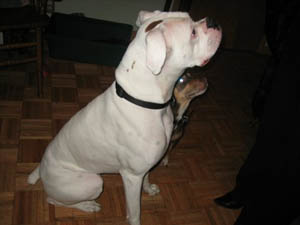

In [8]:
from IPython.display import display
img = '19.jpg'
image = Image.open(img)
display(image)

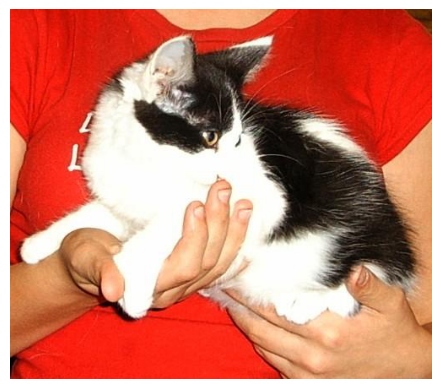

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg

img = '185.jpg'
image = mimg.imread(img)
plt.imshow(image)
plt.axis('off')
plt.show()

We clearly know this is a dog but, let's consult out model to find it's opinion on the picture.

In [ ]:
'''
# for using in Google colab we can directly use uploader widget using this snipped
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    path = "/content/" + fn

    # Ensuring the target size matches what your model was trained with
    img = image.load_img(path, target_size=(150, 150))  # Change to your required size
    x = image.img_to_array(img)  # Convert the image to a NumPy array
    x = np.expand_dims(x, axis=0)  # Add a batch dimension

    # Normalize pixel values (assuming model expects values between 0 and 1)
    x /= 255.0

    classes = model.predict(x)

    # Print the prediction result
    print(f"Prediction: {classes[0][0]}")
    if classes[0][0] > 0.5:
        print(fn, "is a Dog")
    else:
        print(fn, "is a Cat")
'''

In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

def model_classify(image_path):
    img = Image.open(image_path).resize((150, 150))  # Resize to match your model's input size
    x = image.img_to_array(img)  # Convert the image to a NumPy array
    x = np.expand_dims(x, axis=0)  # Add a batch dimension
    x /= 255.0  # Normalize pixel values to [0, 1]
    
    classes = model.predict(x)
    
    print(f"Prediction: {classes[0][0]}")
    if classes[0][0] > 0.5:
        print("The image is a Dog.")
    else:
        print("The image is a Cat.")

In [16]:
image_path = input()
model_classify(image_path)

 19.jpg


1/1 [==============================] - 0s 30ms/step
Prediction: 0.5811848044395447
The image is a Dog.


See our model classified as Dog.

In [17]:
image_path = input()
model_classify(image_path)

 185.jpg


1/1 [==============================] - 0s 65ms/step
Prediction: 0.0001598172530066222
The image is a Cat.


See our model classified as Cat.